In [1]:
import os, shutil
import numpy as np
import matplotlib.pyplot as plt
from cellpose import core, utils, io, models, metrics, denoise
from glob import glob
import cv2
from natsort import natsorted
from skimage import color
from scipy import ndimage
from tools.func import *

from sklearn.cluster import DBSCAN
from nd2reader import ND2Reader


In [9]:
!nvcc --version
!nvidia-smi
use_GPU = core.use_gpu()
yn = ['NO', 'YES']
print(f'>>> GPU activated? {yn[use_GPU]}')

'nvcc' is not recognized as an internal or external command,
operable program or batch file.


>>> GPU activated? NO


'nvidia-smi' is not recognized as an internal or external command,
operable program or batch file.


In [2]:
def process_masks(masks, v, t):
    dets = []
    boxLabels = []

    coords = []
    t_id = 0
    v_id = 0

    for num,mask in enumerate(masks):

        contours, hierarchy = cv2.findContours(image=mask.astype("uint8"), mode=cv2.RETR_TREE, method=cv2.CHAIN_APPROX_NONE) 

        if len(contours) == 0:
            continue

        for nmr, cnt in enumerate(contours):

            area = cv2.contourArea(cnt)
            (x, y), r = cv2.minEnclosingCircle(cnt)

            coords.append([v_id, t_id, x, y, num, area])
            
    if len(coords)>0:
        scan = np.stack((np.stack(coords, axis = 0)[:,2],np.stack(coords, axis = 0)[:,3],np.stack(coords, axis = 0)[:,4]), axis = -1)
        clustering = DBSCAN(eps=30, min_samples=1).fit(scan)
        n_unique = np.unique(clustering.labels_)

        for i in n_unique:
            if i==-1:
                continue

            cond = clustering.labels_==i
            coords_ = scan[cond].mean(axis=0)
            X_ = scan[cond]

            if X_.shape[0]>0:
                dets.append([coords_[0],coords_[1],coords_[2],v,t])
                boxLabels.append(0) #Detect only cells

    return dets, boxLabels

In [9]:

v_id = 0
t_id = 0

save_flag = True
video_path = "G:/instru_projects/TimeLapses/u-wells/collagen/241010_timelapses_collagen_1lines_48h_comments.nd2"
model_path = "C:/Users/lehto/git/InstruProject/NikonPipes/dataStore/img_store/models/modelArttu"

vid_parts = os.path.split(video_path)

results = os.path.split(video_path)[0] + "/results_{}".format(vid_parts[1][:-4])
#results= "."
segments_path =  vid_parts[0] + "/results_{}/{}_detections.pkl".format(vid_parts[1][:-4], vid_parts[1][:-4])
focus_path =  vid_parts[0] + "/results_{}/focus_indixes.pkl".format(vid_parts[1][:-4])

with open(segments_path, 'rb') as f:
    data_dict = pickle.load(f)

with open(focus_path, 'rb') as f:
    focus_dict = pickle.load(f)

day = os.path.split(video_path)[1].split("_")[0]

def NormalizeData(data):
    return (data - np.min(data)) / (np.max(data) - np.min(data))


chan = "Grayscale"
chan2 = "None"

# declare model
model = models.CellposeModel(gpu=True, 
                             pretrained_model=model_path)

diameter =  model.diam_labels

dn = denoise.DenoiseModel(gpu=True, model_type="deblur_cyto3",diam_mean=diameter)


total_dets = []
dets = []
label = []


if save_flag:

    out_name = results + '/detector_{}_{}.mp4'.format( day, v_id )
    out_process = cv2.VideoWriter(out_name, cv2.VideoWriter_fourcc(*"mp4v"), 5, (2304,2304))



with ND2Reader(video_path) as images:
    #c -channel, v - locations, t - time
    
    metas = load_metadata(images)
    images.iter_axes = "vtc"
    images.bundle_axes = "zyx"

    frames_tot = int((metas["n_channels"]*metas["n_fields"]*metas["n_frames"]))

    for idx, img in tqdm.tqdm(enumerate(images),total=frames_tot):
        c_id = idx%metas["n_channels"]
        id_name = metas["channels"][c_id]

        try:
            focus_idx = focus_dict[v_id][t_id]

            if (focus_idx == -1) | (focus_dict[v_id][t_id] == -2):
                t_id += 1
                if t_id == metas["n_frames"]:

                    t_id = 0
                    v_id += 1

                    total_dets = pd.concat(total_dets)
                    total_dets["cell_id"] = np.arange(total_dets.shape[0])
                    total_dets.to_csv(results + '/detector_{}_{}.csv'.format( day, v_id ))

                    total_dets = []

                    if save_flag:
                        out_process.release()

                    if v_id == metas["n_fields"]:
                        break

                    else:
                        if save_flag:
                            out_name = os.path.join(results,'detector_{}_{}.mp4'.format( day, v_id ))
                            out_process = cv2.VideoWriter(out_name, cv2.VideoWriter_fourcc(*"mp4v"), 5, (2304,2304))
                continue
            else:
                pass
        except:
                t_id += 1
                if t_id == metas["n_frames"]:

                    t_id = 0
                    v_id += 1

                    total_dets = pd.concat(total_dets)
                    total_dets["cell_id"] = np.arange(total_dets.shape[0])
                    total_dets.to_csv(results + '/detector_{}_{}.csv'.format( day, v_id ))
                    total_dets = []

                    if save_flag:
                        out_process.release()

                    if v_id == metas["n_fields"]:
                        break

                    else:
                        if save_flag:
                            out_name = os.path.join(results,'detector_{}_{}.mp4'.format( day, v_id ))
                            out_process = cv2.VideoWriter(out_name, cv2.VideoWriter_fourcc(*"mp4v"), 5, (2304,2304))

                continue


        if (id_name != 'Red') : 

            if len(dets) > 0:

                big_idx = data_dict["loc_{}_ch_1".format(v_id)]['big_idx'][t_id]
                spheroid = data_dict["loc_{}_ch_1".format(v_id)]['mask'][t_id][big_idx]

                min_proj = np.min(img, axis = 0)
                normalizedImg = np.zeros_like(min_proj)
                cv2.normalize(min_proj,  normalizedImg, 0, 255, cv2.NORM_MINMAX)
                normalizedImg = normalizedImg.astype("uint8")
                normalizedImg = np.stack((normalizedImg,normalizedImg,normalizedImg),axis = -1)

                cv2.drawContours(normalizedImg, [spheroid], -1, (0,255,0), 3)


                screened = []
                for i in dets:
                    result = cv2.pointPolygonTest(spheroid, (i[0],i[1]), False)
                    if result==-1:
                        cv2.drawMarker(normalizedImg, (int(i[0]), int(i[1])),(255,0,0), markerType=cv2.MARKER_STAR, 
                                markerSize=60, thickness=5, line_type=cv2.LINE_AA)
                        screened.append(i)

                #plt.imshow(normalizedImg)
                #plt.show()

            else:
                min_proj = np.min(img, axis = 0)
                normalizedImg = np.zeros_like(min_proj)
                cv2.normalize(min_proj,  normalizedImg, 0, 255, cv2.NORM_MINMAX)
                normalizedImg = normalizedImg.astype("uint8")
                normalizedImg = np.stack((normalizedImg,normalizedImg,normalizedImg),axis = -1)
                print("No detections")

            if save_flag:
                out_process.write(normalizedImg)
                
            t_id += 1

            if t_id == metas["n_frames"]:

                t_id = 0
                v_id += 1

                total_dets = pd.concat(total_dets)
                total_dets["cell_id"] = np.arange(total_dets.shape[0])
                total_dets.to_csv(results + '/detector_{}_{}.csv'.format( day, v_id ))

                total_dets = []

                if save_flag:
                    out_process.release()

                if v_id == metas["n_fields"]:
                    break
                else:
                    if save_flag:

                        out_name = os.path.join(results,'detector_{}_{}.mp4'.format( day, v_id ))
                        out_process = cv2.VideoWriter(out_name, cv2.VideoWriter_fourcc(*"mp4v"), 5, (2304,2304))

            continue
        
        img_2 = img.copy()
        imgs_ = np.array( dn.eval(list(img), channels=[0,0], diameter=diameter))
        imgs_dn = []

        for num, c_img in enumerate(imgs_):
            imgs_dn.append((NormalizeData(c_img)*(2**16-1)).astype("uint16"))

        # run model on test images
        masks, flows, styles = model.eval(imgs_dn, 
                                        channels=[chan, chan2],
                                        diameter=diameter,
                                        normalize=True
                                        )
        

        dets, label = process_masks(masks, v_id, t_id)
        if len(dets) > 0:
            total_dets.append(pd.DataFrame(np.array(dets), columns=["loc","time","x","y","z"]))


    

  0%|          | 2/1008 [00:50<5:49:35, 20.85s/it] 

No detections


  0%|          | 4/1008 [01:45<6:14:06, 22.36s/it] 

No detections


  1%|          | 6/1008 [02:39<6:13:43, 22.38s/it]

No detections


  1%|          | 10/1008 [04:29<6:21:04, 22.91s/it]

No detections


  1%|          | 12/1008 [05:20<6:06:49, 22.10s/it]

No detections


  1%|▏         | 14/1008 [06:10<5:55:23, 21.45s/it]

No detections


  2%|▏         | 16/1008 [06:56<5:34:57, 20.26s/it]

No detections


  2%|▏         | 18/1008 [07:42<5:24:54, 19.69s/it]

No detections


  2%|▏         | 20/1008 [08:31<5:27:47, 19.91s/it]

No detections


  2%|▏         | 22/1008 [09:16<5:19:32, 19.44s/it]

No detections


  2%|▏         | 24/1008 [10:07<5:30:27, 20.15s/it]

No detections


  3%|▎         | 26/1008 [10:56<5:31:56, 20.28s/it]

No detections


  3%|▎         | 28/1008 [11:38<5:08:56, 18.91s/it]

No detections


  3%|▎         | 30/1008 [12:24<5:08:38, 18.93s/it]

No detections


  3%|▎         | 32/1008 [13:10<5:09:04, 19.00s/it]

No detections


  3%|▎         | 34/1008 [13:57<5:14:03, 19.35s/it]

No detections


  4%|▎         | 36/1008 [14:44<5:13:35, 19.36s/it]

No detections


  4%|▍         | 38/1008 [15:32<5:17:48, 19.66s/it]

No detections


  5%|▍         | 48/1008 [19:54<5:59:32, 22.47s/it]

No detections


  5%|▌         | 52/1008 [21:41<5:54:07, 22.23s/it]

No detections


  9%|▊         | 86/1008 [1:14:24<5:45:43, 22.50s/it]

No detections


  9%|▊         | 88/1008 [1:15:19<5:47:44, 22.68s/it]

No detections


  9%|▉         | 90/1008 [1:16:13<5:45:03, 22.55s/it]

No detections


  9%|▉         | 92/1008 [1:17:05<5:37:36, 22.11s/it]

No detections


  9%|▉         | 94/1008 [1:17:59<5:38:37, 22.23s/it]

No detections


 10%|▉         | 96/1008 [1:18:48<5:23:25, 21.28s/it]

No detections


 10%|▉         | 98/1008 [1:19:38<5:17:39, 20.94s/it]

No detections


 10%|▉         | 100/1008 [1:20:31<5:24:22, 21.43s/it]

No detections


 10%|█         | 102/1008 [1:21:26<5:36:00, 22.25s/it]

No detections


 10%|█         | 104/1008 [1:22:21<5:38:32, 22.47s/it]

No detections


 12%|█▏        | 116/1008 [1:28:01<5:52:57, 23.74s/it]

No detections


 26%|██▌       | 258/1008 [3:36:44<4:45:18, 22.82s/it]

No detections


 59%|█████▉    | 594/1008 [22:16:49<2:38:44, 23.01s/it]

No detections


 60%|██████    | 608/1008 [22:22:54<2:23:15, 21.49s/it]

No detections


 61%|██████    | 610/1008 [22:23:43<2:18:56, 20.95s/it]

No detections


 61%|██████    | 612/1008 [22:24:28<2:10:28, 19.77s/it]

No detections


 61%|██████    | 614/1008 [22:25:20<2:15:09, 20.58s/it]

No detections


 61%|██████    | 616/1008 [22:26:10<2:15:19, 20.71s/it]

No detections


 84%|████████▎ | 842/1008 [25:02:27<1:23:08, 30.05s/it]  

No detections


 84%|████████▎ | 844/1008 [25:03:28<1:15:57, 27.79s/it]

No detections


 84%|████████▍ | 846/1008 [25:04:35<1:15:05, 27.81s/it]

No detections


 84%|████████▍ | 848/1008 [25:05:29<1:06:56, 25.10s/it]

No detections


 84%|████████▍ | 850/1008 [25:06:25<1:03:36, 24.16s/it]

No detections


 85%|████████▍ | 852/1008 [25:07:25<1:03:29, 24.42s/it]

No detections


 85%|████████▍ | 854/1008 [25:08:26<1:03:52, 24.88s/it]

No detections


 85%|████████▍ | 856/1008 [25:09:20<1:00:16, 23.79s/it]

No detections


 85%|████████▌ | 858/1008 [25:10:19<1:00:12, 24.09s/it]

No detections


 85%|████████▌ | 860/1008 [25:11:22<1:01:47, 25.05s/it]

No detections


 86%|████████▌ | 862/1008 [25:12:19<59:26, 24.43s/it]  

No detections


 86%|████████▌ | 864/1008 [25:13:21<1:00:14, 25.10s/it]

No detections


 86%|████████▌ | 866/1008 [25:14:24<1:00:38, 25.62s/it]

No detections


 86%|████████▌ | 868/1008 [25:15:17<55:38, 23.85s/it]  

No detections


 86%|████████▋ | 870/1008 [25:16:23<59:10, 25.72s/it]  

No detections


100%|█████████▉| 1007/1008 [26:40:21<01:35, 95.35s/it]


## Test


In [3]:
def NormalizeData(data):
    return (data - np.min(data)) / (np.max(data) - np.min(data))


video_path = "F:/instru_projects/TimeLapses/u-wells/IPN/241026_Uwell_IPNmix_3lines_166h_mix.nd2"

chan = "Grayscale"
chan2 = "None"
diameter =  500

v_id = 0
t_id = 0
save_flag = False

vid_parts = os.path.split(video_path)
results = os.path.split(video_path)[0] + "/results_{}".format(vid_parts[1][:-4])
segments_path =  vid_parts[0] + "/results_{}/{}_detections.pkl".format(vid_parts[1][:-4], vid_parts[1][:-4])
focus_path =  vid_parts[0] + "/results_{}/focus_indixes.pkl".format(vid_parts[1][:-4])

with open(segments_path, 'rb') as f:
    data_dict = pickle.load(f)

with open(focus_path, 'rb') as f:
    focus_dict = pickle.load(f)

day = os.path.split(video_path)[1].split("_")[0]

dn = denoise.DenoiseModel(gpu=True, model_type="deblur_cyto3",diam_mean=diameter)

if save_flag:

    out_name = results + '/detector_{}_{}.mp4'.format( day, v_id )
    out_process = cv2.VideoWriter(out_name, cv2.VideoWriter_fourcc(*"mp4v"), 5, (2304,2304))


In [20]:
psf =  Gaussian2DKernel(2)
psf.shape

(17, 17)

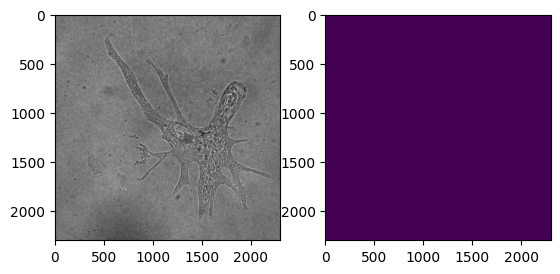

In [23]:

from skimage import color, data, restoration

fig, ax = plt.subplots(1,2)

psf = np.ones((5, 5))/25
psf =  Gaussian2DKernel(5).array

with ND2Reader(video_path) as images:
    img_bf = images.get_frame_2D(c=1, t=10, z=10, x=0, y=0, v=3)
    img_fl = images.get_frame_2D(c=0, t=10, z=10, x=0, y=0, v=3)

img_fl = (img_fl/(np.max(img_fl))*2**8).astype("uint8")
tuned_fl = restoration.richardson_lucy(img_fl, psf, num_iter=15)
img_fl = (tuned_fl/(np.max(tuned_fl))*2**8).astype("uint8")

img_bf = (img_bf/(2**16)*2**8).astype("uint8")

img_bf = np.stack((img_bf,img_bf,img_bf),axis=-1)


ax[0].imshow(img_bf)
ax[1].imshow(img_fl)

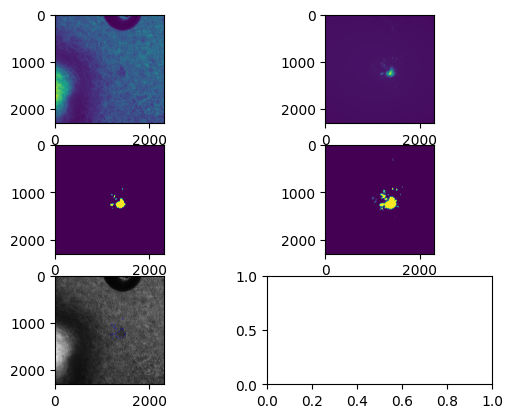

In [42]:
diameter = 100
fig, ax = plt.subplots(3,2)

with ND2Reader(video_path) as images:
    img_bf = images.get_frame_2D(c=1, t=10, z=10, x=0, y=0, v=1)
    img_fl = images.get_frame_2D(c=0, t=10, z=10, x=0, y=0, v=1)

ax[0,0].imshow(img_bf)
ax[0,1].imshow(img_fl)

#img_fl = scipy.ndimage.gaussian_filter(img_fl, (3,3))
imgs_ = dn.eval(img_fl, channels=[0,0], diameter=diameter)
tuned_fl = Kittler_16(imgs_, np.empty_like(imgs_))
org_fl = Kittler_16(img_fl, np.empty_like(img_fl))

ax[1,0].imshow(tuned_fl)
ax[1,1].imshow(org_fl)

frame = (tuned_fl/(2**16)*2**8).astype("uint8")
img_bf = (img_bf/(2**16)*2**8).astype("uint8")
contours, hierarchy = cv2.findContours(image=frame, mode=cv2.RETR_TREE, method=cv2.CHAIN_APPROX_NONE)

img_bf = np.stack((img_bf,img_bf,img_bf),axis=-1)

cv2.drawContours(img_bf, contours, -1, (0, 0, 255), 3)

ax[2,0].imshow(img_bf)

In [7]:
np.max(tuned_fl)

65535.0

In [ ]:



with ND2Reader(video_path) as images:
    #c -channel, v - locations, t - time
    
    metas = load_metadata(images)
    images.iter_axes = "vtc"
    images.bundle_axes = "zyx"

    frames_tot = int((metas["n_channels"]*metas["n_fields"]*metas["n_frames"]))

    for idx, img in tqdm.tqdm(enumerate(images),total=frames_tot):
        c_id = idx%metas["n_channels"]
        id_name = metas["channels"][c_id]
        try:
            focus_idx = focus_dict[v_id][t_id]
            if (focus_idx == -1) | (focus_dict[v_id][t_id] == -2):
                t_id += 1
                if t_id == metas["n_frames"]:

                    t_id = 0
                    v_id += 1

                    total_dets = []

                    if save_flag:
                        out_process.release()

                    if v_id == metas["n_fields"]:
                        break

                    else:
                        if save_flag:
                            out_name = os.path.join(results,'detector_{}_{}.mp4'.format( day, v_id ))
                            out_process = cv2.VideoWriter(out_name, cv2.VideoWriter_fourcc(*"mp4v"), 5, (2304,2304))
                continue
            else:
                pass
        except:
                t_id += 1
                if t_id == metas["n_frames"]:

                    t_id = 0
                    v_id += 1

                    total_dets = pd.concat(total_dets)
                    total_dets["cell_id"] = np.arange(total_dets.shape[0])
                    total_dets.to_csv(results + '/detector_{}_{}.csv'.format( day, v_id ))
                    total_dets = []

                    if save_flag:
                        out_process.release()

                    if v_id == metas["n_fields"]:
                        break

                    else:
                        if save_flag:
                            out_name = os.path.join(results,'detector_{}_{}.mp4'.format( day, v_id ))
                            out_process = cv2.VideoWriter(out_name, cv2.VideoWriter_fourcc(*"mp4v"), 5, (2304,2304))

                continue


        if (id_name != 'Red') : 

            if len(dets) > 0:

                big_idx = data_dict["loc_{}_ch_1".format(v_id)]['big_idx'][t_id]
                spheroid = data_dict["loc_{}_ch_1".format(v_id)]['mask'][t_id][big_idx]

                min_proj = np.min(img, axis = 0)
                normalizedImg = np.zeros_like(min_proj)
                cv2.normalize(min_proj,  normalizedImg, 0, 255, cv2.NORM_MINMAX)
                normalizedImg = normalizedImg.astype("uint8")
                normalizedImg = np.stack((normalizedImg,normalizedImg,normalizedImg),axis = -1)

                cv2.drawContours(normalizedImg, [spheroid], -1, (0,255,0), 3)


                screened = []
                for i in dets:
                    result = cv2.pointPolygonTest(spheroid, (i[0],i[1]), False)
                    if result==-1:
                        cv2.drawMarker(normalizedImg, (int(i[0]), int(i[1])),(255,0,0), markerType=cv2.MARKER_STAR, 
                                markerSize=60, thickness=5, line_type=cv2.LINE_AA)
                        screened.append(i)

                #plt.imshow(normalizedImg)
                #plt.show()

            else:
                min_proj = np.min(img, axis = 0)
                normalizedImg = np.zeros_like(min_proj)
                cv2.normalize(min_proj,  normalizedImg, 0, 255, cv2.NORM_MINMAX)
                normalizedImg = normalizedImg.astype("uint8")
                normalizedImg = np.stack((normalizedImg,normalizedImg,normalizedImg),axis = -1)
                print("No detections")

            if save_flag:
                out_process.write(normalizedImg)
                
            t_id += 1

            if t_id == metas["n_frames"]:

                t_id = 0
                v_id += 1

                total_dets = pd.concat(total_dets)
                total_dets["cell_id"] = np.arange(total_dets.shape[0])
                total_dets.to_csv(results + '/detector_{}_{}.csv'.format( day, v_id ))

                total_dets = []

                if save_flag:
                    out_process.release()

                if v_id == metas["n_fields"]:
                    break
                else:
                    if save_flag:

                        out_name = os.path.join(results,'detector_{}_{}.mp4'.format( day, v_id ))
                        out_process = cv2.VideoWriter(out_name, cv2.VideoWriter_fourcc(*"mp4v"), 5, (2304,2304))

            continue
        
        img_2 = img.copy()
        imgs_ = np.array( dn.eval(list(img), channels=[0,0], diameter=diameter))
        imgs_dn = []

        for num, c_img in enumerate(imgs_):
            imgs_dn.append((NormalizeData(c_img)*(2**16-1)).astype("uint16"))

        # run model on test images
        masks, flows, styles = model.eval(imgs_dn, 
                                        channels=[chan, chan2],
                                        diameter=diameter,
                                        normalize=True
                                        )
        

        dets, label = process_masks(masks, v_id, t_id)
        if len(dets) > 0:
            total_dets.append(pd.DataFrame(np.array(dets), columns=["loc","time","x","y","z"]))


    

In [8]:
label

[]

In [ ]:
# gets image files in dir (ignoring image files ending in _masks)
files = io.get_image_files(dir, '_masks')
print(files)
images = [io.imread(f) for f in files]

In [4]:
from cellpose import models, core
import skimage
from sklearn.cluster import DBSCAN
import pickle
from glob import glob
import os
import cv2
from nd2reader import ND2Reader
import matplotlib.pyplot as plt
import timeit
import tqdm

import numpy as np
from cellpose import denoise

!nvcc --version
!nvidia-smi
use_GPU = core.use_gpu()
yn = ['NO', 'YES']
print(f'>>> GPU activated? {yn[use_GPU]}')

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2022 NVIDIA Corporation
Built on Tue_Mar__8_18:36:24_Pacific_Standard_Time_2022
Cuda compilation tools, release 11.6, V11.6.124
Build cuda_11.6.r11.6/compiler.31057947_0
Fri Jul 26 15:34:09 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 546.59                 Driver Version: 546.59       CUDA Version: 12.3     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                     TCC/WDDM  | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce RTX 3070      WDDM  | 00000000:01:00.0  On |                  N/A |
| 33%   33C    P8    

In [5]:

#Metadata parser
def load_metadata(images):
    meta_dict = {}
     # number of locations start 1


    meta_dict["n_fields"] = images.metadata['fields_of_view'].stop
    #number of timeseteps
    meta_dict["n_frames"] = images.metadata['num_frames']

    
    #meta_dict["z_level"] = (np.max(images.metadata['z_coordinates'])-np.min(images.metadata['z_coordinates']))

    meta_dict["z_level"] =  float(images.metadata["z_coordinates"][:images.metadata["z_levels"].stop][-1]-images.metadata["z_coordinates"][:images.metadata["z_levels"].stop][0])/float(images.metadata["z_levels"].stop)
    #number of levels starting from 1
    meta_dict["n_levels"] = images.metadata['z_levels'].stop
    meta_dict["z_step"] = meta_dict["z_level"] /meta_dict["n_levels"]

    #list of channels
    meta_dict["channels"] = images.metadata['channels']

    #number of channels
    meta_dict["n_channels"] = len(meta_dict["channels"])

    meta_dict["m"] = images.metadata['pixel_microns']
    meta_dict["height"] = images.metadata["height"]
    meta_dict["width"] = images.metadata["width"]

    return meta_dict

class cellpose_class():
  
  def __init__(self, name):

    self.diameter = 50
    self.flow_threshold=0.3 
    self.cellprob_threshold=0
    self.channels = None 

    self.model = self.generate_model(name)

    self.data_dict = {}
    self.meta = None
    self.vis_image = None

  def add_vis_image(self, img):

    img = (img/(2**16)*2**8).astype("uint8")
    img = np.stack((img, img, img), axis = -1)
    self.vis_image = img
  
  def return_vis_image(self, img):
    return self.vis_image

  def add_meta(self,meta):
    self.meta = meta

  def generate_model(self, name):

    initial_model = name #@param ['cyto','nuclei','tissuenet','livecell','cyto2','CP','CPx','TN1','TN2','TN3','LC1','LC2','LC3','LC4','scratch']
    #model_name = "bf_model_test" #@param {type:"string"}

    Channel_to_use_for_training = "Grayscale" #@param ["Grayscale", "Blue", "Green", "Red"]

    # @markdown ###If you have a secondary channel that can be used for training, for instance nuclei, choose it here:
    Second_training_channel= "None" #@param ["None", "Blue", "Green", "Red"]

    #@markdown ###Advanced Parameters

    Use_Default_Advanced_Parameters = True #@param {type:"boolean"}

    # Here we match the channel to number
    if Channel_to_use_for_training == "Grayscale":
      chan = 0
    elif Channel_to_use_for_training == "Blue":
      chan = 3
    elif Channel_to_use_for_training == "Green":
      chan = 2
    elif Channel_to_use_for_training == "Red":
      chan = 1

    if Second_training_channel == "Blue":
      chan2 = 3
    elif Second_training_channel == "Green":
      chan2 = 2
    elif Second_training_channel == "Red":
      chan2 = 1
    elif Second_training_channel == "None":
      chan2 = 0

    if initial_model =='scratch':
      initial_model = 'None'

    self.channels = [chan, chan2]

    return models.CellposeModel(gpu=True, model_type="CP")
  
  def predict(self, img):
    masks, flows, styles = self.model.eval(img, diameter=self.diameter, channels=self.channels)
    return masks, flows, styles
  
  def start_loc(self, loc):
    self.dets = []
    self.boxlabels = []

    self.data_dict[loc] = {}

  def finish_loc(self, loc):

    self.data_dict[loc]["dets"] = self.dets
    self.data_dict[loc]["labels"] = self.boxlabels

    with open(f"./video_dump/detector_out_{loc}.pickle", 'wb') as outp:
        pickle.dump(self.data_dict, outp, pickle.HIGHEST_PROTOCOL)
        
    print("saved output pickle")

  def start_z(self):
    self.tracker_list = []
    self.boxlabels = []

  def finish_z(self):
  
    if len(self.tracker_list) == 0:
      return 0, self.vis_image

    print(self.tracker_list.shape)
    clustering = DBSCAN(eps=30, min_samples=3).fit(self.tracker_list)
    n_unique = np.unique(clustering.labels_)
    
    for i in n_unique:
        if i==-1:
            continue
        cond = clustering.labels_== i

        coords = self.tracker_list[cond].mean(axis=0)
        X_ = self.tracker_list[cond]

        if X_.shape[0]>2:
            
            self.dets.append([coords[0],coords[1],coords[2],1,1])
            self.boxLabels.append(0) #Detect only cells

            cv2.drawMarker(self.vis_image, (coords[0],coords[1]),(36,255,12), markerType=cv2.MARKER_STAR, markerSize=5, thickness=2, line_type=cv2.LINE_AA)
            cv2.putText(self.vis_image, 'z_level {}'.format(coords[2]), (coords[0],coords[1]-10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (36,255,12), 2)
    
    return 1, self.vis_image
  
  def process(self, img_fl, z):

    self.z = z
    masks, flows, styles = self.predict(img_fl)

    success, contours = self.draw_contours(masks.astype("uint8"))

    return success, contours

  
  def draw_contours(self, masks):
    
    contours, _ = cv2.findContours(masks, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    cnt_ = []
    x = []; y = []; z = []
    for cnt in contours:
        
      area = cv2.contourArea(cnt)
      if (area < 120) & (area > 20):
        #cnt_list.append(cnt)
         
        M = cv2.moments(cnt)
        cx = int(M['m10']/M['m00'])
        cy = int(M['m01']/M['m00'])

        x.append(cx); y.append(cy); z.append(self.z) 
        cnt_.append(cnt)
        #plt.imshow(masks)
        #plt.show()


    if len(x) == 0:
      return -1, masks
    
    if self.tracker_list == []:
        self.tracker_list = np.stack((np.asarray(x),np.asarray(y),np.asarray(z)),axis = -1)
    else:
        self.tracker_list = np.concatenate([self.tracker_list,np.stack((np.asarray(x),np.asarray(y),np.asarray(z)),axis = -1)], axis = 0)
    
    return 1, cnt_


In [6]:
root_path = "D:/instru_projects/TimeLapses/u-wells/*"
target_paths = glob(os.path.join(root_path, "*Cherry0*.nd2"))
root_path = "E:/instru_projects/TimeLapses/u-wells/*"
target_paths += glob(os.path.join(root_path, "*Cherry0*.nd2"))

cp = cellpose_class("cyto")

for video_path in target_paths:

    video_name = os.path.split(video_path)[-1][:-4]
    root_path = os.path.split(video_path)[0]
    results = os.path.join(root_path, "results_{}".format(video_name))
    os.makedirs(results, exist_ok=True)
    parts = os.path.split(video_path)[-1].split("_")
    day = str(parts[0])

    with ND2Reader(video_path) as images:

        metas = load_metadata(images)

        focus_path = glob(os.path.join(results, "*_indixes.pkl"))

        if len(focus_path) == 0:
            focus_flag = False
        else:
            focus_flag = True
            with open(focus_path[0], 'rb') as f:
                focus_dict = pickle.load(f)


        if metas["n_channels"] == 2:
            FL_flag = True
        else:
            FL_flag = False

        if FL_flag:
            for d in range(len(metas["channels"])):
                if metas["channels"][d] == 'BF':
                    idx_bf = d
                elif metas["channels"][d] == 'Red':
                    idx_fl = d


        for k in range(metas["n_fields"]): #

            cp.start_loc(k)

            out_name = os.path.join("./video_dump",'{}_{}.mp4'.format(os.path.split(video_path)[1][:-4], (k) ) )
            out_process = cv2.VideoWriter(out_name, cv2.VideoWriter_fourcc(*"mp4v"), 5, (2304,2304))

            for j in range(metas["n_frames"]):
                
                idx = 0
                prev = 0

                if FL_flag:
                    if focus_flag:
                        idx = int(focus_dict[k][j])

                        if idx == -1: #Drifts out of focus, stop tracking
                            break

                        try:
                            img_bf = images.get_frame_2D(c=idx_bf, t=j, z=idx, x=0, y=0, v=k)
                        except:
                            j-=1
                            img_bf = images.get_frame_2D(c=idx_bf, t=j, z=idx, x=0, y=0, v=k)

                    cp.add_vis_image(img_bf)
                    cp.start_z()
                    
                    for z in tqdm.tqdm(range(metas["n_levels"]), total = metas["n_levels"]) :
                        try:
                            img_fl = images.get_frame_2D(c=idx_fl, t=j, z=z, x=0, y=0, v=k)
                        except:
                            j-=1
                            img_fl = images.get_frame_2D(c=idx_fl, t=j, z=z, x=0, y=0, v=k)

                        #img_fl = skimage.filters.gaussian(img_fl, sigma=2)
                        out_vis_, contours_ = cp.process(img_fl, z)
                else:
                    continue

                _, out_image = cp.finish_z()

                #plt.imshow(out_image)
                #plt.show()

                out_process.write(out_image)

            cp.finish_loc(k)
            
            out_process.release()
            #break

model_type does not exist, using default model
100%|██████████| 31/31 [01:09<00:00,  2.23s/it]


saved output pickle


100%|██████████| 31/31 [01:08<00:00,  2.20s/it]


(1, 3)


100%|██████████| 31/31 [01:09<00:00,  2.25s/it]


saved output pickle


100%|██████████| 31/31 [01:09<00:00,  2.25s/it]


saved output pickle


100%|██████████| 31/31 [01:11<00:00,  2.29s/it]


(1, 3)


100%|██████████| 31/31 [01:10<00:00,  2.26s/it]


saved output pickle


100%|██████████| 31/31 [01:10<00:00,  2.27s/it]


saved output pickle


100%|██████████| 31/31 [01:11<00:00,  2.31s/it]


(2, 3)


100%|██████████| 31/31 [01:13<00:00,  2.38s/it]


saved output pickle


100%|██████████| 31/31 [01:11<00:00,  2.30s/it]


(1, 3)


 32%|███▏      | 10/31 [00:23<00:48,  2.33s/it]C:\Users\lehto\AppData\Local\Temp\ipykernel_16892\2844198088.py:183: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if self.tracker_list == []:
100%|██████████| 31/31 [01:11<00:00,  2.29s/it]

(3, 3)


AttributeError: 'cellpose_class' object has no attribute 'boxLabels'

In [17]:
pip install seaborn

   ---------------------------------------- 0.0/294.9 kB ? eta -:--:--
   ---- ----------------------------------- 30.7/294.9 kB 1.3 MB/s eta 0:00:01
   ----------- ---------------------------- 81.9/294.9 kB 1.1 MB/s eta 0:00:01
   ---------------------------------------- 294.9/294.9 kB 2.6 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [6]:
from tools.func import *

In [37]:
from skimage.morphology import closing, dilation
from skimage.morphology import disk

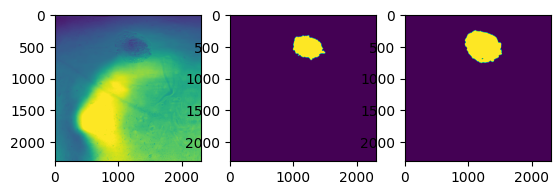

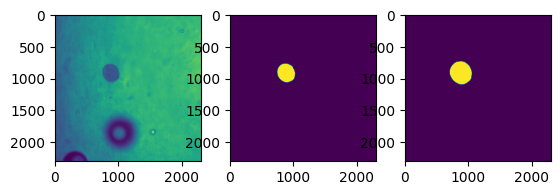

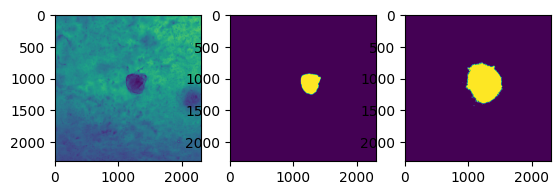

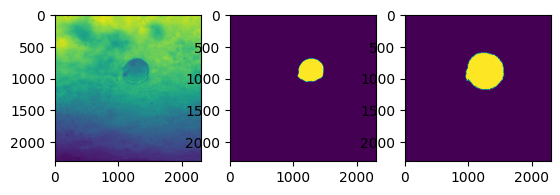

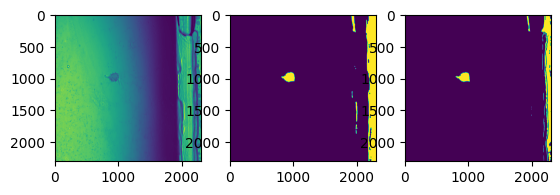

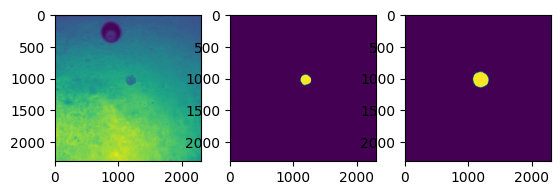

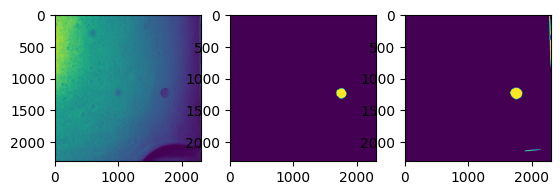

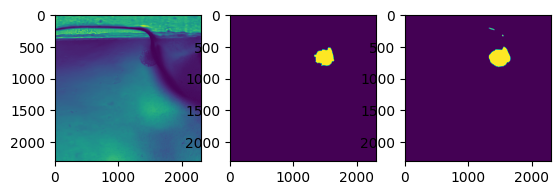

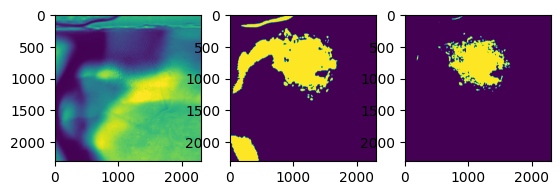

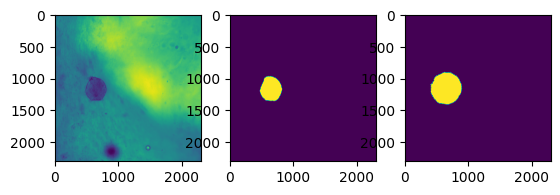

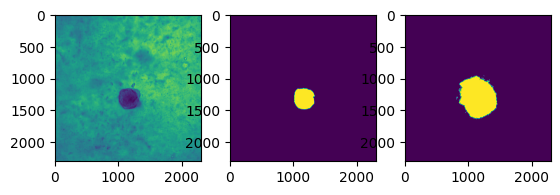

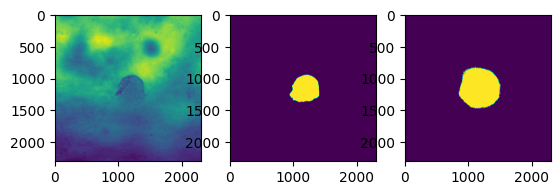

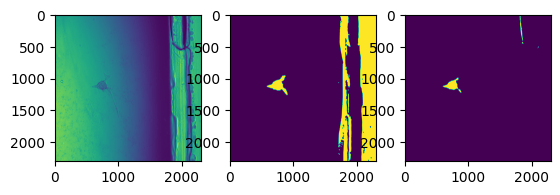

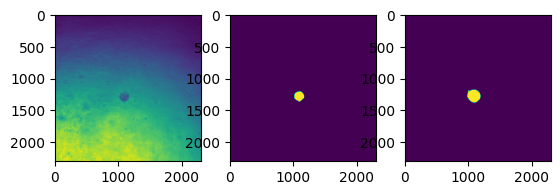

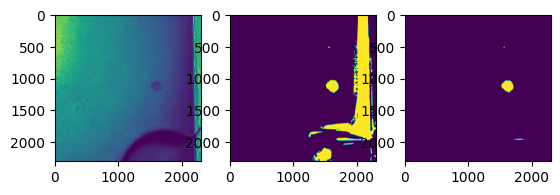

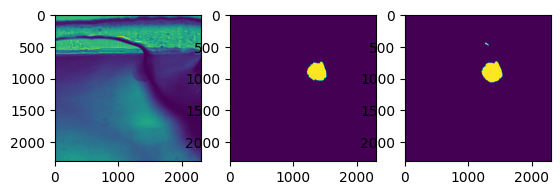

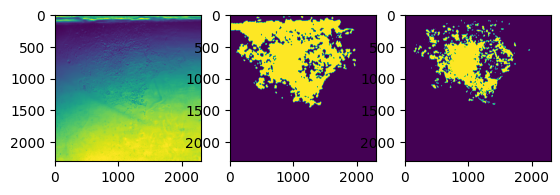

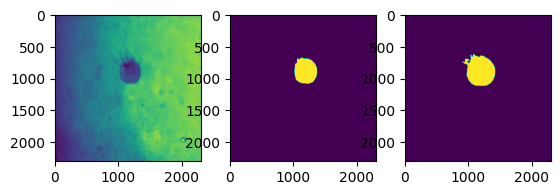

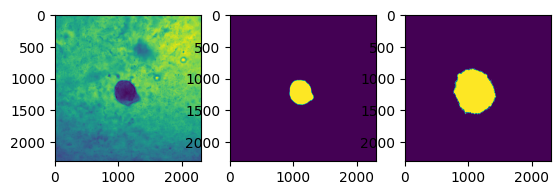

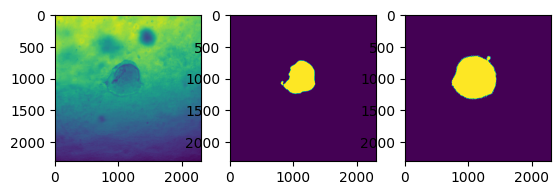

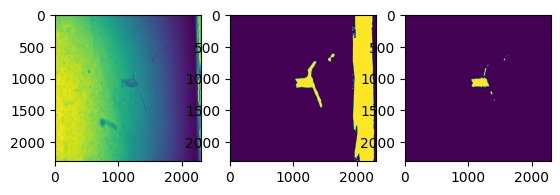

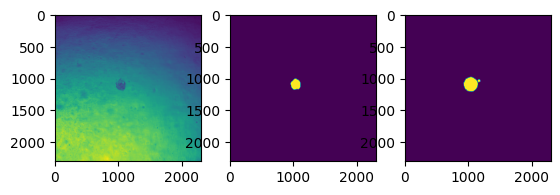

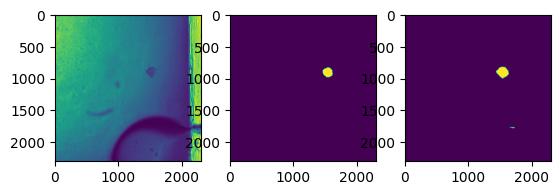

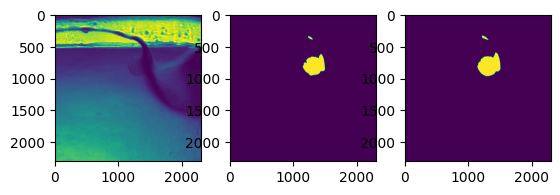

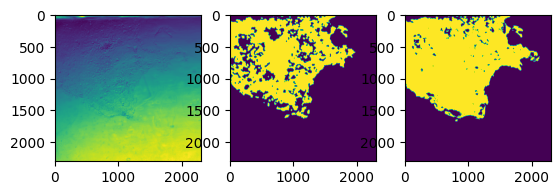

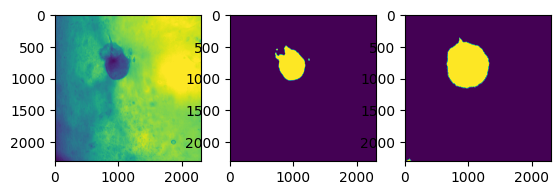

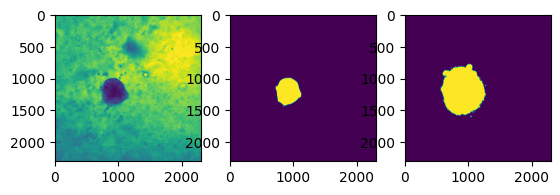

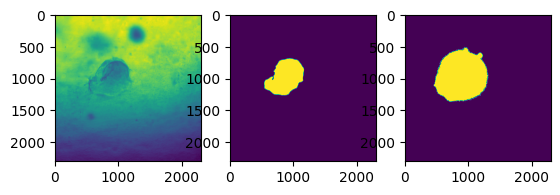

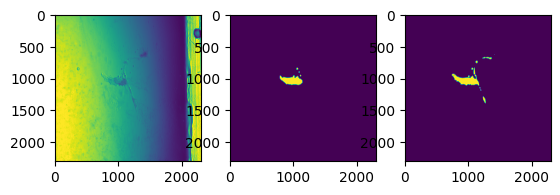

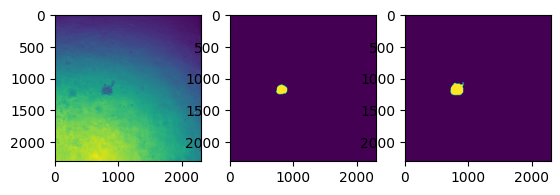

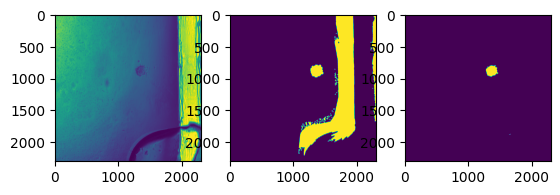

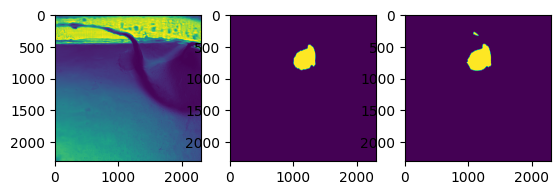

In [39]:

root_path = "E:/instru_projects/TimeLapses/u-wells/*"
target_paths = glob(os.path.join(root_path, "*.nd2"))

dn = denoise.DenoiseModel(model_type="denoise_cyto3", gpu=True)

for video_path in target_paths:

    video_name = os.path.split(video_path)[-1][:-4]
    root_path = os.path.split(video_path)[0]
    results = os.path.join(root_path, "results_{}".format(video_name))
    os.makedirs(results, exist_ok=True)
    parts = os.path.split(video_path)[-1].split("_")
    day = str(parts[0])

    with ND2Reader(video_path) as images:

        metas = load_metadata(images)
        focus_path = glob(os.path.join(results, "*_indixes.pkl"))

        if len(focus_path) == 0:
            focus_flag = False
        else:
            focus_flag = True
            with open(focus_path[0], 'rb') as f:
                focus_dict = pickle.load(f)

        if metas["n_channels"] == 2:
            FL_flag = True
        else:
            FL_flag = False

        if FL_flag:
            for d in range(len(metas["channels"])):
                if metas["channels"][d] == 'BF':
                    idx_bf = d
                elif metas["channels"][d] == 'Red':
                    idx_fl = d


        for k in range(metas["n_fields"]): #

            #out_name = os.path.join("./",'{}_{}.mp4'.format(os.path.split(video_path)[1][:-4], (k)))
            #out_process = cv2.VideoWriter(out_name, cv2.VideoWriter_fourcc(*"mp4v"), 5, (2304,2304))

            for j in range(metas["n_frames"]-1,metas["n_frames"]):
                
                idx = 0
                prev = 0
                idx = int(focus_dict[k][j])
                if idx == -1: #Drifts out of focus, stop tracking
                    break

                img_bf = images.get_frame_2D(c=idx_bf, t=j, z=idx, x=0, y=0, v=k)
                img_fl = images.get_frame_2D(c=idx_fl, t=j, z=idx, x=0, y=0, v=k)

                img_sk = scipy.ndimage.gaussian_filter(img_fl, (2,2))
                #img_sk = img_fl.copy()
                img_sk_ = Kittler_16(img_sk, np.empty_like(img_sk))

                

                #img_fl_ = dn.eval(img_fl, diameter=100, channels = [0,0])
                img_ = scipy.ndimage.gaussian_filter(img_fl, (2,2))
                img_ = skimage.exposure.equalize_adapthist(img_, clip_limit=0.03)
                img_ = cv2.normalize(img_, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX)

                #img_ = (img_/(2**16)*2**8).astype("uint8")
                ret2,th2 = cv2.threshold(img_.astype("uint8"),0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
                th2 = dilation(th2, disk(5))
                th2 = closing(th2, disk(5))
                ##img_fl = scipy.ndimage.gaussian_filter(img_fl, (3,3))
                ##frame = Kittler_16(img_fl, np.empty_like(img_fl_))


                fig, ax  = plt.subplots(1,3)
                #cv2.normalize(img_fl, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX)

                ax[0].imshow(img_bf)
                ax[1].imshow(th2)
                ax[2].imshow(img_sk_)

                #cv2.normalize(frame, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX))
                plt.show()




                #plt.imshow(out_image)
                #plt.show()

                #out_process.write(out_image)


            #out_process.release()
            #break